In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, HBox, VBox, IntSlider, FloatSlider, SelectionSlider, DatePicker, Button, Output, SelectMultiple, Dropdown
from datetime import datetime
from IPython.display import display

In [5]:
# Load data (3 csv)
mid_cap = pd.read_csv("mid_cap.csv")
large_cap = pd.read_csv("large_cap.csv")
us_agg = pd.read_csv("us_agg.csv")

print(mid_cap.shape)
print(large_cap.shape)
print(us_agg.shape) # 50 funds total # 18+12+20

(8705, 19)
(8705, 13)
(8705, 21)


In [6]:
# First column = dates = "as_of"
df = (
    mid_cap.merge(large_cap, on="as_of", how="inner")
           .merge(us_agg, on="as_of", how="inner")
)

# ensure first column is properly formatted # datetime
df['as_of'] = pd.to_datetime(df['as_of'], format='%m/%d/%Y')

In [7]:
df.to_csv("combined_fund_list.csv", index=False)

### Computing Returns – All 50 Mutual Funds

In [8]:
df = df.sort_values(by='as_of', ascending=False) # Sort descending newest -> oldest

prices = df.drop(columns='as_of') # Drop date col

def compute_returns(tau):
    tau = 365  # in yrs! 1,3 or 5 yrs
    future_prices = prices.shift(tau)

    returns = (future_prices - prices) / prices
    returns = returns.dropna() # Drop rows w/ NaN
    return returns

r = compute_returns(365)
r.shape
r.to_csv("Historical_Returns_perFund.csv", index=False)

### Computing Rolling Returns – All 50 Mutual Funds

In [9]:
df = df.sort_values(by='as_of', ascending=False) # Sort descending newest -> oldest

prices = df.drop(columns='as_of') # Drop date col

tau = 365
delta = 5 

def compute_rolling_returns(tau,delta):
    rolling_returns = []
    T = len(prices)
    for t in range(0, T - tau, delta):  
        end_day = t + tau
        p_t = prices.iloc[t]
        p_end = prices.iloc[end_day]
        r = (p_end - p_t) / p_t
        rolling_returns.append(r)
    return pd.DataFrame(rolling_returns)

rolling_r = compute_rolling_returns(tau,delta)
rolling_r.to_csv("Rolling_Returns_perFund.csv", index=False)

In [10]:
# Verifying calculation is correct
tau = 365
delta = 5
roll_r = compute_rolling_returns(tau, delta)

T = len(prices)

L_theoretical = (T - tau + 1) // delta
L_actual = roll_r.shape[0]

print(f"T: {T}")
print(f"tau: {tau}")
print(f"delta: {delta}")
print(f"L_theory: {L_theoretical}")
print(f"L_actual: {L_actual}")

T: 8705
tau: 365
delta: 5
L_theory: 1668
L_actual: 1668


## Part 2: Function to compute historical distribution of mutual funds or portfolios

In [11]:
combined_list = pd.read_csv("combined_fund_list.csv")

In [12]:
# check the formatting
combined_list['as_of'] = pd.to_datetime(combined_list['as_of'], format='%Y-%m-%d')
combined_list = combined_list.set_index('as_of')
combined_list = combined_list.sort_index(ascending=True) # Sort descending newest -> oldest

In [13]:
def historical_distribution(start_date, end_date, tau, d, delta, total_fund_list, selected_funds=None):
    """
    start_date: start date (inclusive)
    end_date: end date (inclusive)

    tau: time horizon in years (1, 3, or 5)
    delta: rolling period (30 for monthly)
    d: number of mutual funds in portfolio

    total_fund_list: list of all available mutual funds
    selected_funds: optional list of funds to analyze
    """

    # isolate the date region
    filtered_total_funds_dates = total_fund_list.loc[start_date: end_date] 

    # check if any funds were selected, ensure that d total funds are selected
    if selected_funds is not None:
        if len(selected_funds) > d:
            picked_funds = np.random.choice(selected_funds, d, replace=False).tolist()
        else:
            picked_funds = selected_funds
    else:
        picked_funds = []
    
    # if less than d funds provided, randomly select from the total fund list
    funds_needed = d - len(picked_funds)
    if funds_needed > 0:
        all_funds = list(filtered_total_funds_dates.columns)
        available_funds = list(set(all_funds) - set(picked_funds))
        picked_funds += np.random.choice(available_funds, funds_needed, replace=False).tolist()
    
    print(f"Selected funds: {picked_funds}")

    # isolate the selected funds
    filtered_funds = filtered_total_funds_dates[picked_funds]
    
    # calculate the rolling returns
    tau = int(tau * 252)  # convert years to days
    returns = (filtered_funds.shift(-tau) - filtered_funds) / filtered_funds

    # rolling periods L 
    L = int(np.floor(((total_fund_list.index.get_loc(end_date) - total_fund_list.index.get_loc(start_date) + 1) - tau + 1) / delta))

    # calculate the rolling returns
    rolling_returns = []

    for i in range(L):
        start_pos = i * delta
        start_return = returns.iloc[start_pos]
        rolling_returns.append(start_return)
    
    rolling_returns = pd.DataFrame(rolling_returns).dropna()

    # combined returns
    combined_returns = rolling_returns.mean(axis=1).dropna()
    return combined_returns

In [14]:
# Example usage
test = historical_distribution(
    start_date="2010-01-01",
    end_date="2015-01-01",
    tau=3,
    d=35,
    delta=14,
    total_fund_list=combined_list,
    selected_funds=['B11293', 'B00774', 'B15709', 'B13835', 'B07347', 'B09833']
)

Selected funds: ['B11293', 'B00774', 'B15709', 'B13835', 'B07347', 'B09833', 'B05011', 'B00450', 'B10749', 'B04312', 'B03193', 'B11999', 'B09550', 'B08336', 'B15851', 'B04841', 'B04313', 'B14867', 'B10612', 'B10363', 'B15191', 'B07223', 'B11222', 'B12997', 'B04687', 'B05548', 'B05947', 'B00241', 'B14965', 'B06850', 'B14908', 'B02390', 'B13086', 'B06096', 'B07245']


In [15]:
test

2010-01-01    0.218219
2010-01-15    0.215955
2010-01-29    0.278505
2010-02-12    0.274142
2010-02-26    0.255840
                ...   
2012-09-21    0.258505
2012-10-05    0.324035
2012-10-19    0.344523
2012-11-02    0.364739
2012-11-16    0.362208
Length: 76, dtype: float64

Var/CVar Calculation

Var: all the periods where the loss exceeds a value^percentile – with alpha% our value will not exceed this value

interpretation: there's an alpha% chance of losing at least $Var, if that happens you expect to lose on average $CVar 

In [16]:
def var_cvar_calculation(returns, alpha, nSims, init_value=1000000):

    # going to use bootstrap method to calculate so we can use the historical data instead of assuming a normal distribution

    sampled_returns = np.random.choice(returns, size=nSims, replace=True)

    # simulate end values/losses
    simulated_end_values = init_value * (1 + sampled_returns)
    losses = init_value - simulated_end_values

    # calculate VaR and CVaR
    sorted_losses = np.sort(losses)
    var = np.percentile(sorted_losses, alpha * 100)
    cvar = sorted_losses[sorted_losses >= var].mean()
    return -var, -cvar


In [17]:
# Example usage
var, cvar = var_cvar_calculation(test, 0.05, 10000)
print(f"VaR: {var:,.2f}")
print(f"CVaR: {cvar:,.2f}")

VaR: 431,373.30
CVaR: 271,453.98


Setup Dashboard

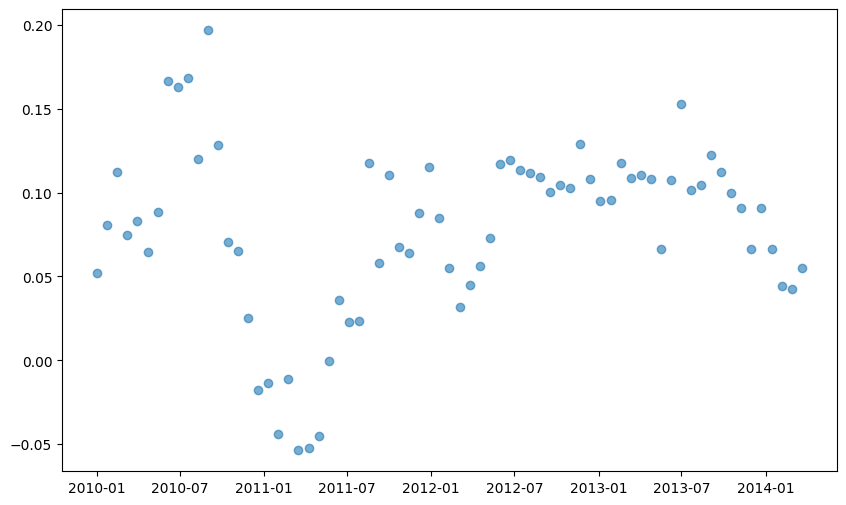

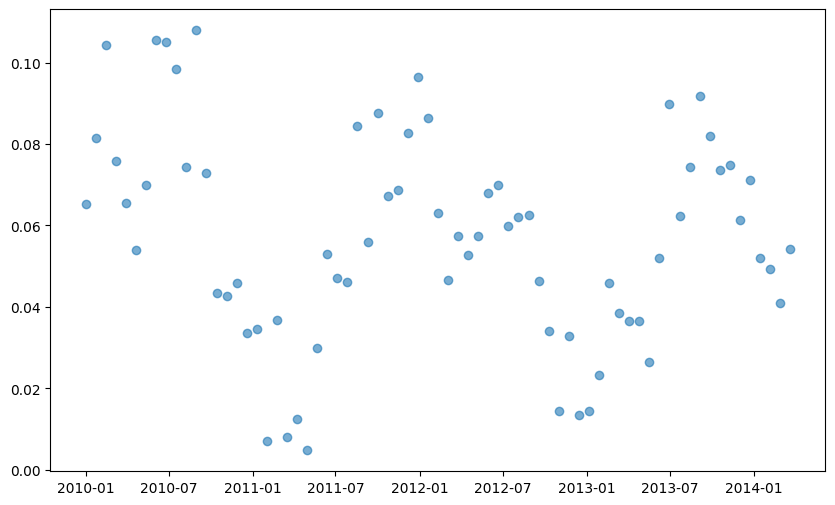

In [30]:
# dropdown pickers for all variables
fund_list = combined_list.columns.tolist() # fund names 

tau_dropdown = Dropdown(options=[1, 3, 5], description='Investment Horizon (Years)', value=1, style={'description_width': 'initial'},
    layout={'width': '400px'})
delta_dropdown = Dropdown(options={'Daily': 1, 'Weekly': 5, 'Monthly': 22, 'Quarterly': 66}, value=22, description='Rolling Period:', style={'description_width': 'initial'},
    layout={'width': '400px'})

alpha_slider = FloatSlider(value=0.05, min=0.01, max=0.5, step = 0.01, description='Confidence Level:', style={'description_width': 'initial'},
    layout={'width': '400px'})
d_slider = IntSlider(value=5, min=1, max=50, step=1, description='Number of Funds:', style={'description_width': 'initial'},
    layout={'width': '400px'})

start_date_picker = DatePicker(description="Start Date:", value=datetime(2010, 1, 1), min=datetime(2005, 12,31), max=datetime(2024, 12, 31))
end_date_picker = DatePicker(description="End Date:", value=datetime(2015, 1, 1), min=datetime(2005, 12,31), max=datetime(2024, 12, 31))

fund_selection = SelectMultiple(options=fund_list, description="Select Funds (optional):", rows=6, style={'description_width': 'initial'},
    layout={'width': '400px'})

submit_button = Button(description="Calculate VaR/CVaR", button_style='primary')
clear_button = Button(description="Clear Outputs", button_style='danger', layout={'width':'auto'})
output_text = Output()
output_plot = Output()


In [31]:
def clear_form(_):
    start_date_picker.value = datetime(2010, 1, 1)
    end_date_picker.value = datetime(2015, 1, 1)
    d_slider.value = 5
    tau_dropdown.value = 1
    delta_dropdown.value = 22
    alpha_slider.value = 0.05
    fund_selection.value = ()
    output_text.clear_output()
    output_plot.clear_output()

clear_button.on_click(clear_form)

In [66]:
# set the button click to calculate VaR/CVaR/historical distribution 
def on_click(b):
    output_text.clear_output()
    output_plot.clear_output()
    with output_text:
        try:
            selected_funds = list(fund_selection.value)
            hist_dis = historical_distribution(start_date_picker.value.strftime('%Y-%m-%d'),
                                               end_date_picker.value.strftime('%Y-%m-%d'),
                                               tau=tau_dropdown.value,
                                               d=d_slider.value,
                                               delta=delta_dropdown.value,
                                               total_fund_list=combined_list,
                                               selected_funds=selected_funds)
            var, cvar = var_cvar_calculation(hist_dis, alpha_slider.value, nSims=10000)
            print(f"VaR: ({(1 - alpha_slider.value) * 100:.0f}%): ${var:,.2f}")
            print(f"CVaR: ({(1 - alpha_slider.value) * 100:.0f}%): ${cvar:,.2f}")

            
            
        except Exception as e:
            print(f"Error: {e}")
            print("Please check your inputs and try again.")
    with output_plot:
        try: 
            # Plot historical distribution

            hist_dis_df = pd.DataFrame({
                "Date": hist_dis.index,
                "Returns": hist_dis.values
            })

            plt.figure(figsize=(10, 6))
            plt.scatter(hist_dis_df['Date'], hist_dis_df['Returns'], alpha=0.6, label='Returns')
            plt.plot(hist_dis_df['Date'], hist_dis_df['Returns'].rolling(window=12).mean(), color='orange', linestyle='--', label='12-Month Avg')
            plt.title('Historical Return Time Series')
            plt.xlabel('Date')
            plt.ylabel('Returns')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Error: {e}")
            print("Please check your inputs and try again.")
        
submit_button.on_click(on_click)
            

In [67]:
# set the UI 
controls_Row = HBox([submit_button, clear_button], layout={"padding": "10px"})
outputs = VBox([output_text, output_plot], layout={"height": "700px", "overflow_y": "auto", "padding": "10px"})
ui = VBox([
    HBox([tau_dropdown, delta_dropdown, alpha_slider], layout={"padding": "15px"}),
    HBox([d_slider], layout={"padding": "15px"}),
    HBox([start_date_picker, end_date_picker], layout={"padding": "15px"}),
    fund_selection,
    controls_Row, 
    outputs
], layout={"height": "1000px", "overflow_y": "auto", "padding": "10px"})

display(ui)